In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 


import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [2]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.58
transformers version : 2.1.1


## 🎬 The example task
The chosen task is a multi-class text classification on [Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview).

For each text movie review, the model has to predict a label for the sentiment. We evaluate the outputs of the model on classification accuracy. The sentiment labels are:
* 0 → Negative
* 1 → Somewhat negative
* 2 → Neutral
* 3 → Somewhat positive
* 4 → Positive

The data is loaded into a ``DataFrame`` using ``pandas``.

In [3]:
DATA_ROOT = Path("sentiment-analysis-on-movie-reviews")
train = pd.read_csv(DATA_ROOT / 'train.tsv.zip', sep="\t")
test = pd.read_csv(DATA_ROOT / 'test.tsv.zip', sep="\t")
print(train.shape,test.shape)
train.head()

(156060, 4) (66292, 3)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [5]:
# Parameters
seed = 42
use_fp16 = False
bs = 64

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [6]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [7]:
#model_class.pretrained_model_archive_map.keys()

In [8]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [9]:
#seed_all(seed)

In [10]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [11]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)


In [12]:

transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [13]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [15]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [16]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

In [17]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [18]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
"<s> Ġ- L RB - ĠCity Ġ- RR B - Ġreminds Ġus Ġhow Ġrealistically Ġnuanced Ġa ĠRobert ĠDe ĠN iro Ġperformance Ġcan Ġbe Ġwhen Ġhe Ġis Ġnot Ġmore Ġluc r atively Ġengaged Ġin Ġthe Ġshameless Ġself - car ic ature Ġof Ġ` ĠAnaly ze ĠThis Ġ' Ġ- L RB - Ġ1999 Ġ- RR B - Ġand Ġ` ĠAnaly ze ĠThat Ġ, Ġ' Ġpromised Ġ- L RB - Ġor Ġthreatened Ġ-",3
"<s> ĠAs Ġwith Ġso Ġmany Ġmerch and ised - to - the - max Ġmovies Ġof Ġthis Ġtype Ġ, Ġmore Ġtime Ġappears Ġto Ġhave Ġgone Ġinto Ġrecruiting Ġthe Ġright Ġbands Ġfor Ġthe Ġplaylist Ġand Ġthe Ġcost uming Ġof Ġthe Ġstars Ġthan Ġinto Ġthe Ġscript Ġ, Ġwhich Ġhas Ġa Ġhandful Ġof Ġsmart Ġjokes Ġand Ġnot Ġmuch Ġelse Ġ. </s>",1
"<s> ĠDirector ĠGeorge ĠH icken lo oper Ġhas Ġhad Ġsome Ġsuccess Ġwith Ġdocumentaries Ġ, Ġbut Ġhere Ġhis Ġsense Ġof Ġstory Ġand Ġhis Ġjuvenile Ġcamera Ġmovements Ġsmack Ġof Ġa Ġfilm Ġschool Ġundergrad Ġ, Ġand Ġhis Ġm aud lin Ġending Ġmight Ġnot Ġhave Ġgotten Ġhim Ġinto Ġfilm Ġschool Ġin Ġthe Ġfirst Ġplace </s>",0
"<s> ĠIn Ġcapturing Ġthe Ġunder stated Ġcomedic Ġagony Ġof Ġan Ġever - rum inating Ġ, Ġg ente el Ġyet Ġdecad ent Ġaristocracy Ġthat Ġcan Ġno Ġlonger Ġpay Ġits Ġbills Ġ, Ġthe Ġfilm Ġcould Ġjust Ġas Ġwell Ġbe Ġaddressing Ġthe Ġturn Ġof Ġthe Ġ20 th Ġcentury Ġinto Ġthe Ġ21 st Ġ. </s>",2
"<s> Ġimagine Ġanyone Ġmanaging Ġto Ġsteal Ġa Ġmovie Ġnot Ġonly Ġfrom Ġcharismatic Ġrising Ġstar ĠJake ĠGy ll en ha al Ġbut Ġalso Ġfrom Ġaccomplished ĠOscar Ġwinners ĠSusan ĠSar andon Ġ, ĠDustin ĠHoffman Ġand ĠHolly ĠHunter Ġ, Ġyet Ġnewcomer ĠEllen ĠPompe o Ġpulls Ġoff Ġthe Ġfeat Ġwith Ġa pl omb </s>",3


In [19]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([64, 79])
tensor([[    0,   111,   574,  ...,    76,   479,     2],
        [    0,   128,    29,  ...,     1,     1,     1],
        [    0,   653,   111,  ...,     1,     1,     1],
        ...,
        [    0,   392,   185,  ...,     1,     1,     1],
        [    0,  1236,  2603,  ...,     1,     1,     1],
        [    0,    20, 24111,  ...,     1,     1,     1]])


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [20]:
from elementwise_sa_layer import PrenormElementwiseUnit
from elementwise_sa_layer import ElemetwiseSaSummarizer

# defining our model architecture 
class CustomPolyModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomPolyModel,self).__init__()
        self.embedding = transformer_model.roberta.embeddings
        self.embedding.requires_grad = False
        embedding_size = 768
        hidden_size = 200
        
        duplicates = 5
        intermediate_size = hidden_size * duplicates
        
        self.reduce_embedding = nn.Linear(embedding_size, hidden_size, bias=False)
        
        self.avg_layer1 = PrenormElementwiseUnit(hidden_size, intermediate_size)
        
        self.avg_layer2 = PrenormElementwiseUnit(hidden_size, intermediate_size)
        
        self.avg_layer3 = PrenormElementwiseUnit(hidden_size, intermediate_size)
        
        self.avg_layer4 = PrenormElementwiseUnit(hidden_size, intermediate_size)
        
        self.avg_layer5 = PrenormElementwiseUnit(hidden_size, intermediate_size)
    
        self.avg_layer6 = PrenormElementwiseUnit(hidden_size, intermediate_size)
        
        self.poly_ln = nn.LayerNorm(hidden_size)
        self.poly_out = ElemetwiseSaSummarizer(hidden_size, intermediate_size)
        
        
        self.fc_out = nn.Linear(intermediate_size, 5)
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 

        #print('HERE')
        embedding = self.embedding(input_ids)
        embedding = self.reduce_embedding(embedding)
        p1 = self.avg_layer1(embedding, attention_mask=attention_mask)
        p2 = self.avg_layer2(p1, attention_mask=attention_mask)
        p3 = self.avg_layer3(p2, attention_mask=attention_mask)
        p4 = self.avg_layer4(p3, attention_mask=attention_mask)
        p5 = self.avg_layer5(p4, attention_mask=attention_mask)
        p6 = self.avg_layer6(p5, attention_mask=attention_mask)
        po = self.poly_out(self.poly_ln(p6), attention_mask=attention_mask)
        out = torch.softmax(self.fc_out(po), dim=-1)
 
        return out

In [21]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)

{
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [22]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomPolyModel(transformer_model = transformer_model)

In [23]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

#CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = AdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))
learner.callbacks.append(SaveModelCallback(learner, monitor='valid_loss', name='esa_models_sigmoid_gate/best_model'))


In [24]:
print(learner.model)

CustomPolyModel(
  (embedding): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (reduce_embedding): Linear(in_features=768, out_features=200, bias=False)
  (avg_layer1): PrenormElementwiseUnit(
    (esa): ElementwiseSaLayer(
      (predict_global): Linear(in_features=200, out_features=1000, bias=False)
      (predict_weight): Linear(in_features=200, out_features=1000, bias=False)
      (predict_gate): Linear(in_features=200, out_features=1000, bias=True)
      (predict_condense): Linear(in_features=1000, out_features=200, bias=False)
      (global_dropout): Dropout(p=0.1, inplace=True)
      (elementwise_dropout): Dropout(p=0.1, inplace=True)
    )
    (fc): FCLayer(
      (norm): LayerNorm((1000,), eps=1e-05, elementwise_affine

In [25]:
learner.save('untrain')

In [26]:
#seed_all(seed)
learner.load('untrain');

In [27]:
#learner.freeze_to(1)

In [28]:
#learner.summary()

In [29]:
#learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.307190,1.314222,0.580994,0.419006,06:36
1,1.280916,1.305181,0.591760,0.408240,07:14
2,1.279667,1.283802,0.615276,0.384724,07:34
3,1.276423,1.278455,0.620851,0.379149,07:35
4,1.281714,1.277288,0.623030,0.376970,06:49
5,1.270455,1.279472,0.619185,0.380815,07:24
6,1.263109,1.265230,0.634051,0.365949,06:38
7,1.266686,1.262407,0.637191,0.362809,06:40
8,1.259601,1.253093,0.646867,0.353133,06:59
9,1.254515,1.254314,0.643535,0.356465,06:28


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


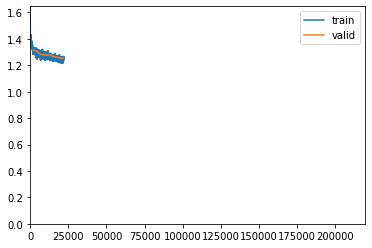

Better model found at epoch 0 with valid_loss value: 1.3142223358154297.


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 1 with valid_loss value: 1.3051809072494507.


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 2 with valid_loss value: 1.2838016748428345.


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 3 with valid_loss value: 1.2784550189971924.


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 4 with valid_loss value: 1.2772876024246216.


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated

Better model found at epoch 6 with valid_loss value: 1.2652298212051392.


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 7 with valid_loss value: 1.262406587600708.


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 8 with valid_loss value: 1.2530927658081055.


/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/mark/miniconda3/envs/elementwise_sa_retry/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated

In [ ]:
learner.fit_one_cycle(100,max_lr=1e-04,pct_start=0.5,moms=(0.8,0.7))

In [ ]:
learner.load('esa_models_sigmoid_gate/best_model');

In [ ]:
#learner.fit_one_cycle(1,max_lr=1e-04,moms=(0.8,0.7))

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
sample_submission = pd.read_csv(DATA_ROOT / 'sampleSubmission.csv')
sample_submission['Sentiment'] = np.argmax(test_preds,axis=1)
sample_submission.to_csv("esa_predictions_new.csv", index=False)

In [ ]:
test.head()

In [ ]:
sample_submission.head()

In [ ]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='poly_predictions_shallower.csv')